In [ ]:
####image shape should be 64,64##############
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
import tensorflow.python.keras.engine
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import os
import random
import scipy.misc
from tqdm import *
import cv2 as cv
import keras.utils as image
#no containers


In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
### Constants ###
ROOT_DIR="/content/drive/My Drive"
DATA_DIR = "/content/drive/My Drive/Colab Notebooks"
SECRETE_DIR = os.path.join(DATA_DIR, "secrete")
COVER_DIR = os.path.join(DATA_DIR, "cover")

IMG_SHAPE = (64, 64)


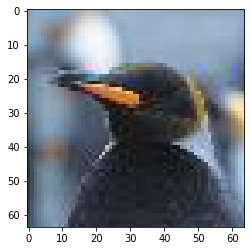

In [ ]:
c_dir = os.path.join(COVER_DIR)
c_imgs = os.listdir(c_dir)

#img_c= cv.imread("/content/drive/My Drive/Colab Notebooks/cover/cover.jpeg")
#resize_cimg=cv.resize(img_c,(64,64))

for img_name_c in c_imgs:
           img_c = image.load_img(os.path.join(c_dir, img_name_c))
           c = image.img_to_array(img_c)
x_cover=np.array(c)

plt.imshow(img_c)



#c_imgs = os.listdir(COVER_DIR)
#img_c = image.load_img(COVER_DIR)
#x = image.img_to_array(img_c)
            #X_train.append(x)
    #random.shuffle(X_train)
    

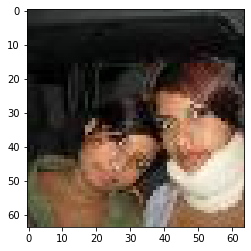

In [ ]:
s_dir = os.path.join(SECRETE_DIR)
s_imgs = os.listdir(s_dir)

#img_s= cv.imread("/content/drive/My Drive/Colab Notebooks/secrete/images.jpeg")
#resize_simg=cv.resize(img_s,(64,64))



for img_name_s in s_imgs:
            img_s = image.load_img(os.path.join(s_dir, img_name_s))
            s = image.img_to_array(img_s)
x_secrete=np.array(s)
plt.imshow(img_s)



In [ ]:
# Normalize image vectors.
x_s=x_secrete/255;
x_c=x_cover/255;




# Load dataset.
#X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
#X_train = X_train_orig/255.
#X_test = X_test_orig/255.

# Print statistics.
print ("Number of secrete examples = " + str(x_s.shape[0]))
print ("Number of cover examples = " + str(x_c.shape[0]))
print ("X_train shape: " + str(x_s.shape)) # Should be (train_size, 64, 64, 3).

Number of secrete examples = 64
Number of cover examples = 64
X_train shape: (64, 64, 3)


In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = x_s[0:]

# C: cover image
input_C = x_c[0:]

In [ ]:
input_S = np.expand_dims(input_S, axis=0)
input_C = np.expand_dims(input_C, axis=0)

In [ ]:


# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

In [ ]:
#load
autoencoder_model.load_weights("/content/drive/My Drive/Colab Notebooks/models/model400.hdf5")


In [ ]:
# Retrieve decoded predictions.
#decoded = autoencoder_model.predict([input_S, input_C])
#decoded_S, decoded_C = decoded[0:3], decoded[3:6]
encoded = encoder_model.predict([input_S, input_C])
decoded = reveal_model.predict([encoded])

1/1 [==============================] - 0s 137ms/step


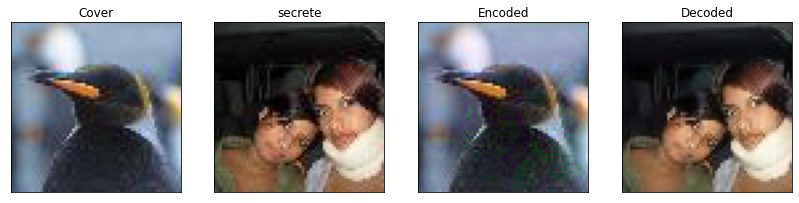

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False

# Number of secret and cover pairs to show.
n =1

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
n_col = 4
for i, idx in enumerate(range(0, n)):
#rand_indx = [random.randint(0,64) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
#for i, idx in enumerate(rand_indx):
    
 show_image(input_C[idx], 1, n_col, 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
 show_image(input_S[idx], 1, n_col, 2, gray=SHOW_GRAY, first_row=i==0, title='secrete')
 show_image(encoded[idx], 1, n_col, 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded')   
 show_image(decoded[idx], 1, n_col, 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded')   

#show_image(img_s, 1, n_col, 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
#show_image(decoded_C[3:6], 1, n_col, 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
#show_image(decoded_S[0:3], 1, n_col, 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    
plt.show()